In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

import matplotlib.pyplot as plt

import numpy as np
np.seterr(all = 'ignore')
from scipy.io import loadmat, savemat

import torch
torch.manual_seed(0)

import time
datetime = time.strftime('%Y%m%d-%H%M%S')
from tqdm import tqdm

from PRModule import *

input data size = (978, 975)


psd: 100%|██████████| 487/487 [00:04<00:00, 103.28it/s]


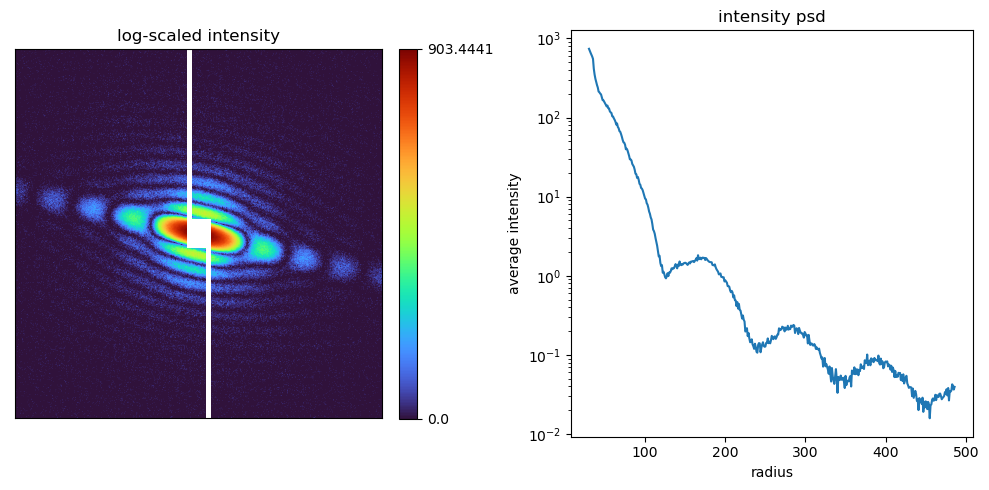

In [2]:
'''
read .mat file and plot input intensity

input data should be intensity
for dpGPS, intensity has to be normalized by photon count
missing data should be masked with NaN
'''

# load input data
path = './sample_au_rod.mat'
key = 'pattern'
intensity = loadmat(path)[key]
unknown = np.isnan(intensity)
print('input data size = {}'.format(intensity.shape))
time.sleep(1)
# plot intensity and psd
QQQ1 = np.log(intensity + 1)
QQQ2 = PSD(intensity, unknown)
plt.figure(figsize = (10, 5), dpi = 100)
plt.subplot(121)
plt.imshow(QQQ1, cmap = 'turbo')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.set_ticks([np.nanmin(QQQ1), np.nanmax(QQQ1)])
cbar.set_ticklabels([np.nanmin(intensity), np.nanmax(intensity)])
plt.title('log-scaled intensity')
plt.subplot(122)
plt.plot(QQQ2)
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('average intensity')
plt.title('intensity psd')
plt.tight_layout()
plt.show()

In [ ]:
'''
generate support


'''

In [6]:
info = {
    'algorithm' : 'GPS-R', # [HIO, GPS-R, GPS-F, dpGPS-R, dpGPS-F]
    'error' : 'R', # [R, NLL]
    'shrinkwrap' : True, # [True, False]

    # parameters of HIO
    'beta' : 0.9, # projection coefficient
    'boundary_push' : 0.1, # final boundary push stage ratio in total iteration
    # common parameters of GPS, dpGPS
    'sigma' : (0, 0.01, 0.4, 0.1, 0.7, 1), # parameter for relaxing magnitude constraint
    'alpha_count' : 10, # number of finer frequency filter for relaxing support constraint
    # parameters of GPS
    't' : 1, # parameter of proximal operator on magnitude constraint
    's' : 0.9, # parameter of proximal operator on support constraint

    # dpGPS setting
    'limit' : 0.25, # preconditioner value range [1-limit, 1+limit]
    'deep' : True, # whether to select deep learning-based preconditioner or not
    # shrinkwrap setting
    'sigma_initial' : 3, # initial sigma
    'sigma_limit' : 1.5, # lower boundary of sigma
    'ratio_update' : 0.01, # sigma update ratio
    'threshold' : 0.1, # threshold for defining new support
    'interval' : 50, # shrinkwrap interval
}

{'algorithm': 'GPS-R', 'error': 'R', 'shrinkwrap': True, 'beta': 0.9, 'boundary_push': 0.1, 'sigma': (0, 0.01, 0.4, 0.1, 0.7, 1), 'alpha_count': 10, 't': 1, 's': 0.9, 'limit': 0.25, 'deep': True, 'sigma_initial': 3, 'sigma_limit': 1.5, 'ratio_update': 0.01, 'threshold': 0.1, 'interval': 50}
